## Setup

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Chapter10"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Perceptrons

Scikit-Learn provides a Perceptron class that implements a single LTU (linear threshold unit) network. It can be used pretty much as we would expect.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


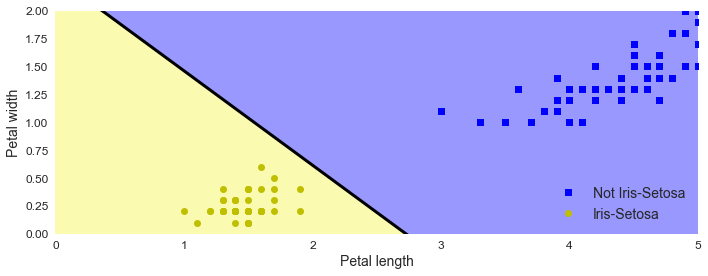

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

## Activation functions

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


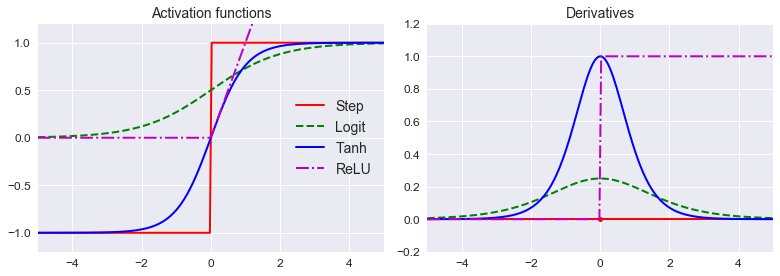

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()


In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

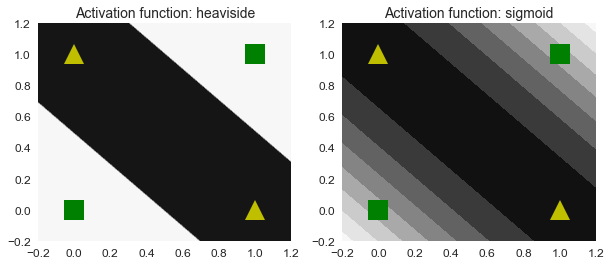

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## FNN for MNIST

### FNN for MNIST

The simplest way to train an MLP with TensorFlow is to use the high-level API TF.Learn, which offers a Scikit-Learn-compatible API. The DNNClassifier class makes it fairly easy to train a deep neural network with any number of hidden layers, and a softmax output layer to output estimated class probabilities.

Under the hood, the DNNClasiffier class creates all the neuron layers, based on the ReLU activation function (we can change this by setting the activation_fn hyperparameter). The output layer relies on the softmax function, and the cost function is crossentropy.

In [9]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [11]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=40000)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x125a62358>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/r4/vyv94gpj7_xdkpj85lw7gpdr0000gn/T/tmplg2nia96'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create 

INFO:tensorflow:global_step/sec: 183.906
INFO:tensorflow:loss = 0.0113093, step = 6901 (0.541 sec)
INFO:tensorflow:global_step/sec: 143.534
INFO:tensorflow:loss = 0.0190613, step = 7001 (0.699 sec)
INFO:tensorflow:global_step/sec: 167.443
INFO:tensorflow:loss = 0.00409009, step = 7101 (0.596 sec)
INFO:tensorflow:global_step/sec: 179.339
INFO:tensorflow:loss = 0.0582136, step = 7201 (0.559 sec)
INFO:tensorflow:global_step/sec: 150.45
INFO:tensorflow:loss = 0.00672715, step = 7301 (0.664 sec)
INFO:tensorflow:global_step/sec: 151.454
INFO:tensorflow:loss = 0.0127499, step = 7401 (0.661 sec)
INFO:tensorflow:global_step/sec: 163.794
INFO:tensorflow:loss = 0.005338, step = 7501 (0.613 sec)
INFO:tensorflow:global_step/sec: 138.813
INFO:tensorflow:loss = 0.0160609, step = 7601 (0.718 sec)
INFO:tensorflow:global_step/sec: 173.37
INFO:tensorflow:loss = 0.00499156, step = 7701 (0.582 sec)
INFO:tensorflow:global_step/sec: 134.318
INFO:tensorflow:loss = 0.00483353, step = 7801 (0.741 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 169.363
INFO:tensorflow:loss = 0.00237104, step = 15101 (0.587 sec)
INFO:tensorflow:global_step/sec: 180.968
INFO:tensorflow:loss = 0.00227502, step = 15201 (0.554 sec)
INFO:tensorflow:global_step/sec: 169.829
INFO:tensorflow:loss = 0.00141252, step = 15301 (0.588 sec)
INFO:tensorflow:global_step/sec: 174.491
INFO:tensorflow:loss = 0.00455337, step = 15401 (0.573 sec)
INFO:tensorflow:global_step/sec: 176.122
INFO:tensorflow:loss = 0.00491852, step = 15501 (0.570 sec)
INFO:tensorflow:global_step/sec: 169.811
INFO:tensorflow:loss = 0.00487903, step = 15601 (0.587 sec)
INFO:tensorflow:global_step/sec: 179.843
INFO:tensorflow:loss = 0.0134273, step = 15701 (0.556 sec)
INFO:tensorflow:global_step/sec: 173.302
INFO:tensorflow:loss = 0.00312125, step = 15801 (0.577 sec)
INFO:tensorflow:global_step/sec: 167.37
INFO:tensorflow:loss = 0.000708232, step = 15901 (0.601 sec)
INFO:tensorflow:global_step/sec: 174.245
INFO:tensorflow:loss = 0.00560298, step = 16001 (0.

INFO:tensorflow:loss = 0.00224091, step = 23201 (0.549 sec)
INFO:tensorflow:global_step/sec: 175.485
INFO:tensorflow:loss = 0.00193402, step = 23301 (0.569 sec)
INFO:tensorflow:global_step/sec: 181.048
INFO:tensorflow:loss = 0.000599899, step = 23401 (0.552 sec)
INFO:tensorflow:global_step/sec: 178.831
INFO:tensorflow:loss = 0.000690191, step = 23501 (0.558 sec)
INFO:tensorflow:global_step/sec: 180.722
INFO:tensorflow:loss = 0.0006689, step = 23601 (0.556 sec)
INFO:tensorflow:global_step/sec: 178.651
INFO:tensorflow:loss = 0.000450027, step = 23701 (0.559 sec)
INFO:tensorflow:global_step/sec: 182.891
INFO:tensorflow:loss = 0.00181704, step = 23801 (0.545 sec)
INFO:tensorflow:global_step/sec: 165.608
INFO:tensorflow:loss = 0.00110625, step = 23901 (0.604 sec)
INFO:tensorflow:global_step/sec: 171.172
INFO:tensorflow:loss = 0.000971603, step = 24001 (0.587 sec)
INFO:tensorflow:global_step/sec: 143.661
INFO:tensorflow:loss = 0.000599703, step = 24101 (0.693 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.000428765, step = 31301 (0.552 sec)
INFO:tensorflow:global_step/sec: 182.239
INFO:tensorflow:loss = 0.000609493, step = 31401 (0.547 sec)
INFO:tensorflow:global_step/sec: 184.502
INFO:tensorflow:loss = 0.00025601, step = 31501 (0.539 sec)
INFO:tensorflow:global_step/sec: 175.724
INFO:tensorflow:loss = 8.65842e-05, step = 31601 (0.570 sec)
INFO:tensorflow:global_step/sec: 185.853
INFO:tensorflow:loss = 0.000604256, step = 31701 (0.541 sec)
INFO:tensorflow:global_step/sec: 182.877
INFO:tensorflow:loss = 9.59904e-05, step = 31801 (0.544 sec)
INFO:tensorflow:global_step/sec: 181.593
INFO:tensorflow:loss = 0.00079322, step = 31901 (0.552 sec)
INFO:tensorflow:global_step/sec: 179.496
INFO:tensorflow:loss = 0.000262161, step = 32001 (0.555 sec)
INFO:tensorflow:global_step/sec: 183.177
INFO:tensorflow:loss = 0.000368648, step = 32101 (0.548 sec)
INFO:tensorflow:global_step/sec: 187.553
INFO:tensorflow:loss = 0.00113988, step = 32201 (0.531 sec)
INFO:tensorflow:global_s

INFO:tensorflow:loss = 0.00066551, step = 39401 (0.590 sec)
INFO:tensorflow:global_step/sec: 160.678
INFO:tensorflow:loss = 0.000248625, step = 39501 (0.624 sec)
INFO:tensorflow:global_step/sec: 164.942
INFO:tensorflow:loss = 0.000750375, step = 39601 (0.606 sec)
INFO:tensorflow:global_step/sec: 164.513
INFO:tensorflow:loss = 0.000224784, step = 39701 (0.608 sec)
INFO:tensorflow:global_step/sec: 179.645
INFO:tensorflow:loss = 0.00105966, step = 39801 (0.556 sec)
INFO:tensorflow:global_step/sec: 176.77
INFO:tensorflow:loss = 0.00136582, step = 39901 (0.567 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /var/folders/r4/vyv94gpj7_xdkpj85lw7gpdr0000gn/T/tmplg2nia96/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00045437.


SKCompat()

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Restoring parameters from /var/folders/r4/vyv94gpj7_xdkpj85lw7gpdr0000gn/T/tmplg2nia96/model.ckpt-40000


0.98240000000000005

In [14]:
from sklearn.metrics import log_loss

y_pred_proba = y_pred['probabilities']
log_loss(y_test, y_pred_proba)

0.071563045266568537

### Using plain TensorFlow

In [15]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [17]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [18]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

The sparse_softmax_cross_entropy_with_logits() function is equivalent to applying the softmax activation function and then computing the cross entropy, but it is more efficient, and it properly takes care of corner cases like logits equal to 0. There is also another function called softmax_cross_entropy_with_logits(), which takes labels in the form of one-hot vectors (instead of ints from 0 to the number of classes minus 1).

In [19]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [20]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

We will simply use accuracy as performance measure. First, for each instance, determine if the neural network's prediction is correct by checking whether or not the highest logit corresponds to the target class. For this we can use the in_top_k() function. This returns a 1D tensor full of boolean values, so we need to cast these booleans to floats and then computes the average.

In [21]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
n_epochs = 40
batch_size = 50

In [24]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                            y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.9 Test accuracy: 0.9128
1 Train accuracy: 0.94 Test accuracy: 0.9291
2 Train accuracy: 0.92 Test accuracy: 0.9398
3 Train accuracy: 0.96 Test accuracy: 0.945
4 Train accuracy: 0.92 Test accuracy: 0.9513
5 Train accuracy: 0.94 Test accuracy: 0.9543
6 Train accuracy: 0.98 Test accuracy: 0.9556
7 Train accuracy: 0.96 Test accuracy: 0.9593
8 Train accuracy: 0.92 Test accuracy: 0.9625
9 Train accuracy: 0.96 Test accuracy: 0.9645
10 Train accuracy: 0.98 Test accuracy: 0.9651
11 Train accuracy: 0.94 Test accuracy: 0.967
12 Train accuracy: 1.0 Test accuracy: 0.9691
13 Train accuracy: 0.94 Test accuracy: 0.9684
14 Train accuracy: 1.0 Test accuracy: 0.9697
15 Train accuracy: 1.0 Test accuracy: 0.9714
16 Train accuracy: 1.0 Test accuracy: 0.9714
17 Train accuracy: 0.98 Test accuracy: 0.9715
18 Train accuracy: 1.0 Test accuracy: 0.973
19 Train accuracy: 1.0 Test accuracy: 0.973
20 Train accuracy: 0.98 Test accuracy: 0.9736
21 Train accuracy: 1.0 Test accuracy: 0.974
22 Train ac

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [26]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


### Using dense() instead of neuron_layer()

In [27]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [28]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [29]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)        # the default activation is None
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [30]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [31]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [32]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [33]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.9 Test accuracy: 0.9053
1 Train accuracy: 0.88 Test accuracy: 0.9206
2 Train accuracy: 0.94 Test accuracy: 0.9301
3 Train accuracy: 0.94 Test accuracy: 0.9397
4 Train accuracy: 0.92 Test accuracy: 0.945
5 Train accuracy: 0.94 Test accuracy: 0.9476
6 Train accuracy: 0.92 Test accuracy: 0.9514
7 Train accuracy: 0.98 Test accuracy: 0.9547
8 Train accuracy: 0.96 Test accuracy: 0.9569
9 Train accuracy: 0.94 Test accuracy: 0.9605
10 Train accuracy: 0.92 Test accuracy: 0.962
11 Train accuracy: 0.96 Test accuracy: 0.9631
12 Train accuracy: 1.0 Test accuracy: 0.966
13 Train accuracy: 0.94 Test accuracy: 0.9656
14 Train accuracy: 1.0 Test accuracy: 0.967
15 Train accuracy: 0.94 Test accuracy: 0.9682
16 Train accuracy: 0.96 Test accuracy: 0.97
17 Train accuracy: 0.98 Test accuracy: 0.9695
18 Train accuracy: 1.0 Test accuracy: 0.97
19 Train accuracy: 1.0 Test accuracy: 0.9708


## Exercise

## 9.

Question: Train a deep MLP on the MNIST dataset and see if you can get over 98% precision. Just like in the last exercise of chapter 9, try adding all the bells and whistles (i.e., save checkpoints, restore the last checkpoint in case of an interruption, add summaries, plot learning curves using TensorBoard, and so on).

First let's create the deep net. It's exactly the same as earlier, with just one addition: we add a tf.summary.scalar() to track the loss and the accuracy during training, so we can view nice learning curves using TensorBoard.

In [35]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [36]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [37]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [38]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [39]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [40]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [41]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [43]:
logdir = log_dir("mnist_dnn")

Now we can create the FileWriter that we will use to write the TensorBoard logs:

In [44]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

To implement early stopping, we are going to need a validation set. Luckily, the dataset returned by TensorFlow's input_data() function (see above) is already split into a training set (60,000 instances, already shuffled for us), a validation set (5,000 instances) and a test set (5,000 instances). So we can easily define X_valid and y_valid:

In [45]:
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

In [46]:
m, n = X_train.shape

In [47]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Epoch: 0 	Validation accuracy: 90.440% 	Loss: 0.35228
Epoch: 5 	Validation accuracy: 95.060% 	Loss: 0.17547
Epoch: 10 	Validation accuracy: 96.700% 	Loss: 0.12552
Epoch: 15 	Validation accuracy: 97.220% 	Loss: 0.10435
Epoch: 20 	Validation accuracy: 97.620% 	Loss: 0.08917
Epoch: 25 	Validation accuracy: 97.740% 	Loss: 0.08117
Epoch: 30 	Validation accuracy: 97.800% 	Loss: 0.07792
Epoch: 35 	Validation accuracy: 97.940% 	Loss: 0.07099
Epoch: 40 	Validation accuracy: 97.920% 	Loss: 0.06977
Epoch: 45 	Validation accuracy: 97.880% 	Loss: 0.06771
Epoch: 50 	Validation accuracy: 98.080% 	Loss: 0.06640
Epoch: 55 	Validation accuracy: 98.080% 	Loss: 0.06644
Epoch: 60 	Validation accuracy: 98.180% 	Loss: 0.06517
Epoch: 65 	Validation accuracy: 98.120% 	Loss: 0.06589
Epoch: 70 	Validation accuracy: 98.100% 	Loss: 0.06755
Epoch: 75 	Validation accuracy: 98.160% 	Loss: 0.06710
Epoch: 80 	Validation accuracy: 98.140% 	Loss: 0.06709
Epoch: 85 	Validation accuracy: 98.200% 	Loss: 0.06713
Epoch: 90 	V

In [48]:
os.remove(checkpoint_epoch_path)

In [49]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from ./my_deep_mnist_model


In [50]:
accuracy_val

0.9788